# Toxic comments - Iteration # 4

### Date: 1st Dec 2020
Sherry

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

## Data cleaning and pruning - not incorporated yet

In [3]:
# exploring the dataset - not used in model-building
train_dataset = pd.read_csv('../../data/toxiccomments_train.csv')


In [4]:
train_dataset[train_dataset.comment_text == 'Sorry Monkey the page got locked while we figure out who you are and report you to your employer.  YOU got pwned!   User:DONNY PWNED YOU']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
90865,f3175595f7f157e3,Sorry Monkey the page got locked while we figu...,0,0,0,0,0,0


# Function for feature building and extraction on natural language data

#### Changes made to feature building and extraction:
  1. **added bigrams**
  
        `hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))`
        
        
  2. **added smooth_idf parameter as False**
  
        `TfidfTransformer(smooth_idf=False)`
        
        
  3. **Added two features: question counts and exclamation counts**
            `toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")`
            `toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")`
       

In [14]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False, strip_accents = 'ascii', ngram_range=(3,5), stop_words='english', analyzer = 'word')
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")

    
#     toxic_data['allcaps_count'] = toxic_data['comment_text'].str.findall(r'[A-Z]').str.len()

#     X_quant_features = toxic_data[["word_count", "exclaim_count", "allcaps_count"]]
    X_quant_features = toxic_data[["word_count", "exclaim_count", "quest_count"]]
#     X_quant_features = toxic_data[["word_count", "exclaim_count"]]


    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.00001, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [15]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [21]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [16]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143344, 'TP': 16201, 'TN': 143318, 'FP': 26, 'FN': 24, 'Accuracy': 0.9996866559294099, 'Precision': 0.9983977321747705, 'Recall': 0.9985208012326656, 'desc': 'svm_train'}


### MODEL: logistic regression

In [17]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143344, 'TP': 16196, 'TN': 143324, 'FP': 20, 'FN': 29, 'Accuracy': 0.9996929228108217, 'Precision': 0.998766650222003, 'Recall': 0.9982126348228043, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143344, 'TP': 15662, 'TN': 135469, 'FP': 7875, 'FN': 563, 'Accuracy': 0.947120054647206, 'Precision': 0.6654204019203807, 'Recall': 0.9653004622496147, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [19]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143344, 'TP': 16192, 'TN': 143324, 'FP': 20, 'FN': 33, 'Accuracy': 0.9996678552851744, 'Precision': 0.998766345916605, 'Recall': 0.9979661016949153, 'desc': 'prc_train'}


### MODEL: SVM-C

In [20]:
from sklearn.svm import LinearSVC
svmc_0002 = LinearSVC(loss='hinge', C=0.0002)
svmc_0002.fit(X_train, y_train)

svmc_0002_performance_train = BinaryClassificationPerformance(svmc_0002.predict(X_train), y_train, 'svmc_0002_train')
svmc_0002_performance_train.compute_measures()
print(svmc_0002_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'Pos': 16225, 'Neg': 143344, 'TP': 16176, 'TN': 143324, 'FP': 20, 'FN': 49, 'Accuracy': 0.9995675851825856, 'Precision': 0.9987651271918992, 'Recall': 0.996979969183359, 'desc': 'svmc_0002_train'}


### MODEL: Ridge Regression Classifier

#### Changes made to ridge regression classifier:

  1. **change alphas to 800, 50, 30, 20, 25, 35, 50000**
  
          
  2. **added normalization parameter and changed the solver to the SAG methodology**
  
        `normalize=True, solver='sag'`
        
        This doesn't work on higher alphas though - error of scalars
        
       

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [21]:
rdg_800 = linear_model.RidgeClassifier(alpha = 800, normalize=True, solver='sag')
rdg_800.fit(X_train, y_train)

rdg_800_performance_train = BinaryClassificationPerformance(rdg_800.predict(X_train), y_train, 'rdg_800_train')
rdg_800_performance_train.compute_measures()
print(rdg_800_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 12481, 'TN': 141453, 'FP': 1891, 'FN': 3744, 'Accuracy': 0.9646861232444899, 'Precision': 0.8684247147230726, 'Recall': 0.7692449922958398, 'desc': 'rdg_800_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [22]:
rdg_50 = linear_model.RidgeClassifier(alpha = 50, normalize=True, solver='sag')
rdg_50.fit(X_train, y_train)

rdg_50_performance_train = BinaryClassificationPerformance(rdg_50.predict(X_train), y_train, 'rdg_50_train')
rdg_50_performance_train.compute_measures()
print(rdg_50_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 15383, 'TN': 133523, 'FP': 9821, 'FN': 842, 'Accuracy': 0.9331762435059442, 'Precision': 0.6103396286303762, 'Recall': 0.9481047765793529, 'desc': 'rdg_50_train'}


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [23]:
from sklearn import linear_model
rdg_30 = linear_model.RidgeClassifier(alpha = 30, normalize=True, solver='sag')
rdg_30.fit(X_train, y_train)

rdg_30_performance_train = BinaryClassificationPerformance(rdg_30.predict(X_train), y_train, 'rdg_30_train')
rdg_30_performance_train.compute_measures()
print(rdg_30_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 15700, 'TN': 131596, 'FP': 11748, 'FN': 525, 'Accuracy': 0.9230865644329412, 'Precision': 0.5719906732730983, 'Recall': 0.9676425269645609, 'desc': 'rdg_30_train'}


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [24]:
from sklearn import linear_model
rdg_20 = linear_model.RidgeClassifier(alpha = 20, normalize=True, solver='sag')
rdg_20.fit(X_train, y_train)

rdg_20_performance_train = BinaryClassificationPerformance(rdg_20.predict(X_train), y_train, 'rdg_20_train')
rdg_20_performance_train.compute_measures()
print(rdg_20_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 15898, 'TN': 129849, 'FP': 13495, 'FN': 327, 'Accuracy': 0.9133791651260583, 'Precision': 0.54087707957677, 'Recall': 0.9798459167950694, 'desc': 'rdg_20_train'}


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [25]:
from sklearn import linear_model
rdg_25 = linear_model.RidgeClassifier(alpha = 25, normalize=True, solver='sag')
rdg_25.fit(X_train, y_train)

rdg_25_performance_train = BinaryClassificationPerformance(rdg_25.predict(X_train), y_train, 'rdg_25_train')
rdg_25_performance_train.compute_measures()
print(rdg_25_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 15793, 'TN': 130868, 'FP': 12476, 'FN': 432, 'Accuracy': 0.9191070947364463, 'Precision': 0.5586685061374651, 'Recall': 0.9733744221879815, 'desc': 'rdg_25_train'}


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [26]:
from sklearn import linear_model
rdg_35 = linear_model.RidgeClassifier(alpha = 35, normalize=True, solver='sag')
rdg_35.fit(X_train, y_train)

rdg_35_performance_train = BinaryClassificationPerformance(rdg_35.predict(X_train), y_train, 'rdg_35_train')
rdg_35_performance_train.compute_measures()
print(rdg_35_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143344, 'TP': 15598, 'TN': 132202, 'FP': 11142, 'FN': 627, 'Accuracy': 0.92624507266449, 'Precision': 0.5833208676140613, 'Recall': 0.9613559322033899, 'desc': 'rdg_35_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [27]:
from sklearn import linear_model
rdg_50000 = linear_model.RidgeClassifier(alpha = 50000)
rdg_50000.fit(X_train, y_train)

rdg_50000_performance_train = BinaryClassificationPerformance(rdg_50000.predict(X_train), y_train, 'rdg_50000_train')
rdg_50000_performance_train.compute_measures()
print(rdg_50000_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143344, 'TP': 15772, 'TN': 143309, 'FP': 35, 'FN': 453, 'Accuracy': 0.9969417618710401, 'Precision': 0.9977857911052066, 'Recall': 0.9720801232665639, 'desc': 'rdg_50000_train'}


### MODEL: Random Forest Classifier

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

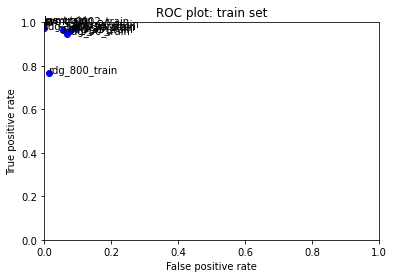

In [28]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train,rdg_30_performance_train,rdg_20_performance_train, rdg_25_performance_train, rdg_35_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [29]:
rdg_predictions = rdg_25.predict(X_train)

In [30]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
553
Friend of yours? 

∇∆∇∆
* * * * * * * * * 
1176
Pathetic little tosser. Get a real life instead of wasting it away on here. New IP addresses can be obtained in 20 seconds LOL
* * * * * * * * * 
1517
"

 Current club 

Oh come on!!  A little common sense and being less nit picky?!  Obviously he doesn't play for ""free agent FC"" or ""FC Unattached""!  Or instead of using ""free agent"" or ""unattached"", I actually put for his current club, ""currently without a club""...  You're going to interpret that as De Jong being contracted to ""FC currently without a club""?!?  You're also telling me that when a player is listed in a national team article and they're club is listed as ""unattached"", because they're literally without a club, they actually play for a team called ""Unattached FC"" or the like?! LOL!!!  Come on!!   "
* * * * * * * * * 
1567
Hoffa Hoffa Hoffa! Buried in a brick! 

Why talk to elevators when no marbles are present?
* * * * * * * * * 


14058
Am I not allowed to write on my own user page?!?!?!!
* * * * * * * * * 
14076
Hey Alexbulg! Don't get such angry! There is no need for wasting time to talk to crazy guys like M...! You know, God created them to amuse really thinking people like us! Best Greetings, Micha.
* * * * * * * * * 
14171
In the past 

The situation is under control
* * * * * * * * * 
14302
For better or worse you can't, WP:NCM
* * * * * * * * * 
14870
King of Kvenland 

Only a Swede would try to insert Charles IX in an article about the Kings of Kvenland. I'll forgive you your nationalistic aspirations, but you must realize that Charles IX had nothing whatsoever to do with the ancient Kvenland.http://www.emersonkent.com/images/maps/europe_814.jpg Do you realize that?
* * * * * * * * * 
14897
jesus christ get a life man
* * * * * * * * * 
15071
"
 Yes, wiki... get your facts ""staright"". 69.77.245.238  "
* * * * * * * * * 
15243
, 8 August 2009 (UTC)

I just saw Xeno's edit comment - A Phone Call????? Tha

25385
well to be honest I do like it here, alot more action here, but yeah I do have full reign on the OLTL Wikia, nobody ever goes on there at least I don't think, I keep it update at least, boy when I first started they had the cast from August 2006 up. 68.114.218.113
* * * * * * * * * 
25514
I dont care. I have at least one proof link. You are so stupid that you dont know how to translate my link. And of couse you dont have any argument or link. Additionaly you must read discussion page. And again. T-72 dont have any ammo in turret.
* * * * * * * * * 
25991
"

Goethean can bite me

Make no mistake, I have ABSOLUTELY no respect for your beliefs and methods of intellectual thuggery, bullying... You're a little man, pathetic and cowardly - intellectual, spiritual, and morally corrupt...your shameful ways of gaming Wikirulez, and other equally low games, in order to foist your rotten and flawed points of view, is reflective of your ethics I have seen on wikipeidia for years now. Your ro

35880
Denying the oppression that Arabs have inflicted on Jews for centuries is anti-Semitic and should not be tolerated on Wikipedia.
* * * * * * * * * 
36232
So not a rip-off 

This is, like, the best book ever. You just need to get into it.
* * * * * * * * * 
36328
I don't understand Sir. Whatever did I do wrong?
* * * * * * * * * 
36466
To respond, even Yugi can't get reception! Ya think that YGO, being one of the biggest, most populat tv series' in both Japan and USA would ahve some character reception....
* * * * * * * * * 
36781
REDIRECT Talk:1973 Nepal plane hijack
* * * * * * * * * 
36878
Oh well. It's a pretty ridiculous request, if I think about it. Thanks for your time, k6ka. Amirasyidazhar
* * * * * * * * * 
36969
Al Ameer son, you yourself should be banned. On your user page you endorse a dictator (Nasser of Egypt) who said once that Israel should be burned to the ground and that all Jews should be thrown to the sea. Shame on YOU!! This is becoming a joint Arab venture I 

48207
But eminem knows this kid named angel and he allways goes to eminems house he has a mother named rocio and a father named alfonso
* * * * * * * * * 
48351
You will NEVER stop me. D
* * * * * * * * * 
48538
What a bunch of smug twats these tory people really are. The only good thing about them is when they get into power Scotland will become independent.
* * * * * * * * * 
48623
"

What? I'm blocked again! I've only edited my userpage since Willmcw blocked me! Now I can't even do that!   "
* * * * * * * * * 
48891
Ummm....while you are at it..please request that management at Wikipedia remove my page, discussions etc...I am done with even trying to understand this place...I will neve come back..and would hope instead of blocking me...you remove my account outright....kapesh?
* * * * * * * * * 
48901
Nacreous cloud article 

I'll edit whatever I damn well please, whenever I damn well please.  I don't care what you or Bill Connolley have to say about anything.  By the way, you're th

59604
Heeeeeeeeeeeeeeyyyyyyyyyyyy dude! Sup!
* * * * * * * * * 
59818
getting your priorities right 

I don't like the idea of using any kind of food with my mastrabating....I just feel like I am using food to have fun while so many other people around the world are starving...I just don't think it's a very moral thing to do.
* * * * * * * * * 
60317
owners of Wikipedia to kick Chad Bryant out of here.  He has a history of doing nothing but fake online fighting with every person he comes in contact with.
* * * * * * * * * 
60354
"::Well, he may claim that he sees it as evidence of ""anti-Semitism"" on WP, but I don't think this is the case. I have never, ever heard anyone, no matter their ethnic or religious background, complain about the ancestors of Iranians and Indians being called ""Aryans."" And why not? Because that is what they were called! LOL Man, it's just so stupid I can't believe we're even discussing this bullshit to death. Funny thing about the swastika - it's not exactly

70556
Hahaha, you are welcome and thanks! I was trying not to hurt the infobox's feelings.
* * * * * * * * * 
71207
BlackPearl you must be very un educated with computers then 86.158.238.188
* * * * * * * * * 
71326
Look, stop messing up McMath Secondary School 's page. Please grow up and learn the rules here. Further violations will just get you banned.
* * * * * * * * * 
72014
My apologies and I swear to you upon Lord Jesus that it will never happen again. 204.69.190.254
* * * * * * * * * 
72158
So MastCell, I see you are resorting back to your internet bullying tactics. Surely it must get rather exhausting censoring material you don't like. If you were really comfortable in your opinions, you would not have the need to censor conflicting information.  If a random person had taken the time to read my block appeal, who would they side with, you or me?
* * * * * * * * * 
72503
"

I've got another Barnstar. Yeh.  (leave me a message!) "
* * * * * * * * * 
72598
thre are 8 million specim

78277
dont listen to anonmoos.
* * * * * * * * * 
78489
Stay out of private business between me and FridgeMagnet.
 Thank you.
* * * * * * * * * 
78823
NO! 

No I told you to stop! Just leave me alone! I will do whatever and i will come back no matter what!!!!!!!!!!
173.51.203.228
* * * * * * * * * 
79015
So what right did you have to delete her off the list and denounce her coloratura abilities if you were actually deaf? everyone was happy and fine until you and some others were destroying, manipulating, and changing the category. What was your reason?
* * * * * * * * * 
79188
I'm not very wiki-proficient and am a bit busy with my (rather crappY) full-time job, so I'm afraid there's not much I can do either (. I guess he'll get away with it. 138.251.242.2
* * * * * * * * * 
79652
check the nick twitter.
* * * * * * * * * 
79770
"It's other way around in Serbia. Women date or have sex with ""bad boys"", but they always marry not nice guys, but total wimps. The more of a wimp you are, th

89478
PAGE I TRIED TO CREATE IS NOW AN ACTUAL PAGE LOL YOU BANNED ME FOR NOTHING
* * * * * * * * * 
89512
wow and now i bet u feel like a big man on wikipedia cause blocked me and wont respond maybe u should grow a pair and realise wikipedia is usless in real life espaecially because any paper using it as a source will just be failed so get off ur high hourse and be a man  all i did was try and stop unwarrented censorship and get someone admit they were wrong for warning my ip
* * * * * * * * * 
91120
"
That long list of vices, but no sex? WP really is bad for you! talk "
* * * * * * * * * 
91252
Also who are you in Wikia and how do you know me?( )
* * * * * * * * * 
91419
Highway of Life talk page.
* * * * * * * * * 
91788
"
HELLO Liberal MAGGOT Part TWO a
Censorship will not make me go away... thanks to you, Rob, I am now using my influence, to undermine the crediablity of Wikipedidiots, like you, and Wikipedia.  To bad you don't want to acknowledge the fact that you and your kind ar

101583
You are a mean one Mr. Grinch.
* * * * * * * * * 
102253
First of all Mokele having the job of editing a website is a job that belongs to none ,especially you so I don't see why you guys are allowed to edit at all.
* * * * * * * * * 
102531
don't edit the Upton page again. If you vandalize it again you will be banned.
* * * * * * * * * 
102576
hey halbared i didmt know youre a wrestler. p.s im the guy who keeps arguing on the brock lesnar page hahaha.
* * * * * * * * * 
102587
Dude, don't worry about her. She will be just fine when she calms down.
* * * * * * * * * 
102910
Ha, next time I have some sort of template problem, do I have to get a sock out of the drawer to post on your talk page? )
* * * * * * * * * 
103153
Look, someone let me off. I admit I have tempural problems, but I can improve them. Maybe talk something over with someone instead. Just let me down from here. Make me an administrator, and I'll shut up those with smart-mouths. For good. Can we all agree?
* * * * 

Oi! Who gave you permission to revert my edit on User talk:LightandDark2000?
* * * * * * * * * 
112866
If some people are anti-catholic then their just biggots.
* * * * * * * * * 
112881
"
I'm sick to death of the ""I'm right and you're wrong"" mentality purveying Wikipedia lately. 204.69.190.254  "
* * * * * * * * * 
113355
A question 
Hello, are you related to the Malaysian golfer Danny Chia?
* * * * * * * * * 
113449
why 

did you delete my page on exhaust modifications?
there was no personal attack involved.
thanks!
Wolfgirl
* * * * * * * * * 
113768
File:Turk Bilge Tonyukuk Monument.jpg 

What is your reason that it violates copyright policy?
* * * * * * * * * 
113836
Why are such biased references added to the Honours section? 188.81.115.107
* * * * * * * * * 
113981
Dude 

you can't vandalize the sandbox why do you keep reverting my edits. anything goes in the SANDBOX.
* * * * * * * * * 
115724
" November 2006 (UTC)
alright dude, but this grass hopper can't handle english this i

122029
PredecessorsTONY BLAIRS A TOSSER BNP FOR BRITAIN
* * * * * * * * * 
122069
"

 Oh yeah 

Indeed. Boogie Dahn. ;-) khoi "
* * * * * * * * * 
122462
Please don't revert my edits, this is your last warning. Thank you.
* * * * * * * * * 
122586
"

 Climate ""science"" its going down! 

Dear Mr Connolley. A few years ago you made the stupid mistake of banning me for trying to put a link to peak oil in the global warming article. That was one hell of a mistake! You personally caused me (at that time a strong supporter of man-made global warming) to go and look at the ""science"" and what I found simply disgusted me. You literally have no idea how active I have been undermining this disgusting scam that you are your friends have been involved with.

So, as a kind of thankyou for setting me straight, I just thought that as you were so influential in getting me involved in climate scepticism, that you'd like to be the first to know: ""it's going down!"".   "
* * * * * * * * * 
122679
Uni

128806
Cassianto 

Hi. I received an email from someone asking me to comment on this page about guys called Cassianto and Shro Cat. The email said you're being harassed. Never heard of Shro Cat, but Cassianto was some pitiful, obsequious little cunt who implied that I ought to show respect for someone who writes crappy featured articles. I told Cassianto to FO; I told him not to contact me again. The creep came back once. I ignored it. 

To be frank, you need to learn how to deal with this. Forums and online communities are full of creeps, social inadequates, born losers, stalkers and mentally unstable zeros. Tell them to FO and ignore them. 

Respectfully, I don't want any further emails (or comments on my talk page) about this. I'm really not interested. Ignore this piece of shit Cassianto and it'll leave you alone.
* * * * * * * * * 
129052
who is going to block me 

is it you who decides who gets blocked
* * * * * * * * * 
129516
"
Oh dear. I suppose I am now at the mercy of the ""

144379
David Roati 

you want my page deleted?

http://en.wikipedia.org/wiki/David_Roati
* * * * * * * * * 
144483
have a look here for footage of Peter Hore the Serial Pest
http://www.hawkmoore.blogspot.com/
* * * * * * * * * 
144725
(watching) whatever you want to present to your talk page guests goes to User talk:Liz/Editnotice, see for example mine, which includes a nod to the one who told me ;)
* * * * * * * * * 
144898
October 2008 (UTC)
From G2's page. The Canadian republican movement likely needs every nickel they can get.   20:29, 8
* * * * * * * * * 
144959
"
Yes, Boon is a joke. So is M Hughes Ranted ''''  (cricket calendar poll!'') "
* * * * * * * * * 
145510
and there will ALWAYS be more IP #'s than you could possibly chase down in your desperate little lives.  Learn from it.  207.237.233.142
* * * * * * * * * 
145718
I agree. I think you might want to re-ask your dad, and go over the whole IQ thing with him. Like Sarahgal said, only 2% of the population have an IQ over 13

I can't modify/delete my own talk?
* * * * * * * * * 
158920
"

WHAT PART OF ""YOU CANT VANDALIZE THE SANDBOX"" DO YOU NOT UNDERSTAND?"
* * * * * * * * * 
159080
Images I find on Google are now available to the public to use. I added half the information on the Altiyan Childs page, so don't try and take the credit. If you used your brain, you would know that no where, and I repeat NO WHERE can I see a visible copyright. I don't think someone took the picture from the Kylie Minogue article on their camera, nor the picture from the Spice Girls, Beyonce, Leona Lewis articles. Stop trolling.
* * * * * * * * * 
159223
Who even are you, and why are you talking to me?
* * * * * * * * * 


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [30]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [31]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'svm_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: logistic regression

In [32]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'lgs_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: Naive Bayes

In [33]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'nbs_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: Perceptron

In [34]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)


{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'prc_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: SVM-C

In [35]:
svmc_0002_performance_test = BinaryClassificationPerformance(svmc_0002.predict(X_test), y_test, 'svmc_0002_test')
svmc_0002_performance_test.compute_measures()
print(svmc_0002_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'svmc_0002_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: Ridge Regression Classifier

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [36]:
rdg_800_performance_test = BinaryClassificationPerformance(rdg_800.predict(X_test), y_test, 'rdg_800_test')
rdg_800_performance_test.compute_measures()
print(rdg_800_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_800_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [37]:
rdg_50_performance_test = BinaryClassificationPerformance(rdg_50.predict(X_test), y_test, 'rdg_50_test')
rdg_50_performance_test.compute_measures()
print(rdg_50_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_50_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [38]:
rdg_30_performance_test = BinaryClassificationPerformance(rdg_30.predict(X_test), y_test, 'rdg_30_test')
rdg_30_performance_test.compute_measures()
print(rdg_30_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_30_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [39]:
rdg_20_performance_test = BinaryClassificationPerformance(rdg_20.predict(X_test), y_test, 'rdg_20_test')
rdg_20_performance_test.compute_measures()
print(rdg_20_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_20_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [40]:
rdg_25_performance_test = BinaryClassificationPerformance(rdg_25.predict(X_test), y_test, 'rdg_25_test')
rdg_25_performance_test.compute_measures()
print(rdg_25_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_25_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [41]:
rdg_35_performance_test = BinaryClassificationPerformance(rdg_35.predict(X_test), y_test, 'rdg_35_test')
rdg_35_performance_test.compute_measures()
print(rdg_35_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_35_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [42]:
rdg_50000_performance_test = BinaryClassificationPerformance(rdg_50000.predict(X_test), y_test, 'rdg_50000_test')
rdg_50000_performance_test.compute_measures()
print(rdg_50000_performance_test.performance_measures)

{'Pos': 0, 'Neg': 2, 'TP': 0, 'TN': 2, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_50000_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


### MODEL: Random Forest Classifier

In [43]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

<ipython-input-44-b37d300d07ca>:10: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-44-b37d300d07ca>:12: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy 

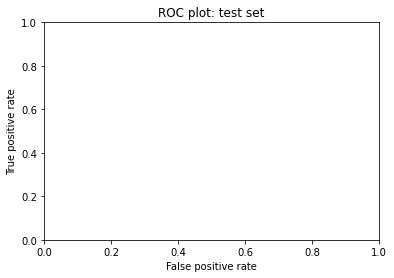

<ipython-input-44-b37d300d07ca>:24: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-44-b37d300d07ca>:26: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


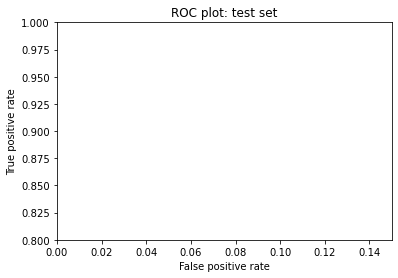

In [44]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, svmc_0002_performance_test]
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test,svmc_0002_performance_test]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

fits_small = [svm_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test, rdg_800_performance_test, svmc_0002_performance_test]


for fit in fits_small:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.15, 0.8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [45]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../../data/toxiccomments_test.csv', my_random_seed=1999, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          72              0            0
1          13              0            0
2          16              0            0
3          38              0            0
4           7     

---
In this iteration, I am choosing the **Ridge Regression (alpha = 25, solver = 'sag')** model fit, which is in the `rdg_25` object. 

In [47]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg_20.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())


0.3123971690475569


In [37]:
raw_data.head()

,id,comment_text,word_count,exclaim_count,quest_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,0,0


In [38]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [39]:
my_submission.shape

(153164, 2)

In [40]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('submission/toxiccomments_submission_iter_4.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation